In [12]:
import imagehash
import pandas as pd
import numpy as np
import requests
from PIL import Image
import os
from imagededup.methods import PHash

from imagededup.methods import CNN
from imagededup.utils import plot_duplicates
import csv

import matplotlib.pyplot as plt
import networkx as nx
import scipy.linalg as la
import math
from collections import defaultdict

# MemeRank Check In

So our project is designed to determine as a more organic method of determining a subreddit rank based on meme content shared with other subreddits.  The subreddit which contains the most memes with formats found in other subreddits will float to the top of our ranking system.

In [5]:
Memes = pd.read_csv("MemeDatabase.csv", encoding='UTF-8',skip_blank_lines=False)

In [6]:
column = Memes["Subreddit"]
thing=Memes.Subreddit.unique()
print(len(thing))


76


So we have 76 unique Subreddits that we are pulling data from, from this it seems fair that we should be able to use a matrix for the Pagerank model.

In [9]:
cleanMemes=Memes.dropna()
condition = cleanMemes["Imagelink"].str.contains(".jpg")
cleanerMemes = cleanMemes[condition]

Many of the memes are NA or gif so we went ahead and removed those from the database to clean the dataset.

In [ ]:
tol=20
for i,m in enumerate(cleanerMemes):
    image_data = Image.open(requests.get("https://memegenerator.net/img/instances/31131375/spiderman-is-doomed.jpg", stream=True).raw)
    hashed1 = imagehash.phash(image_data)
    image_data = Image.open(requests.get("https://img.tineye.com/result/595d5d88b1f875202380301704d2155b6aeca25d13306f3a462982ed3e856837?size=160", stream=True).raw)
    hashed2 = imagehash.phash(image_data)

In [29]:
image_data = Image.open(requests.get("https://memegenerator.net/img/instances/31131375/spiderman-is-doomed.jpg", stream=True).raw)
hashed1 = imagehash.phash(image_data)
image_data = Image.open(requests.get("https://img.tineye.com/result/595d5d88b1f875202380301704d2155b6aeca25d13306f3a462982ed3e856837?size=160", stream=True).raw)
hashed2 = imagehash.phash(image_data)
print(hashed2-hashed1)

10


We should use less than between 10 and 20 for successful comparisons, anything over 25 is definitely not a match.

In [11]:
tol=15
image_base = Image.open(requests.get(cleanerMemes['Imagelink'][1], stream=True).raw)
hashBase=imagehash.phash(image_base)
matches=[]
for index, row in cleanerMemes.iterrows():
    if index>10:
        break
    try:
        image_data = Image.open(requests.get(row['Imagelink'], stream=True).raw)
        image_data.save(os.path.join('/Users/Sid/Documents/FestoProject/MemeProject/Images', row['Imagelink']), quality=85)
    except:
        continue
    hashed1 = imagehash.phash(image_data)
    if (hashBase-hashed1<tol) :
        matches.append(row['Imagelink'])

In [12]:
for index, row in cleanerMemes.iterrows():
    if index<50000:
        continue
    if index>50000:
        break
    try:
        image_data = Image.open(requests.get(row['Imagelink'], stream=True).raw)
        image_data.save(os.path.join('/Users/Sid/Documents/FestoProject/MemeProject/Images', 'image'+str(index)+'.jpg'), quality=85)
    except:
        continue

First we ripped the entire image set from Reddit so that we could run the CNN over the image data locally.

In [7]:
image_data = Image.open(requests.get("https://memegenerator.net/img/instances/31131375/spiderman-is-doomed.jpg", stream=True).raw)
image_data.save(os.path.join('/Users/Sid/Documents/FestoProject/MemeProject/Images', 'image.jpg'), quality=85)

In [ ]:
phasher = CNN()

# Generate encodings for all images in an image directory
encodings = phasher.encode_images(image_dir='/Users/Sid/Documents/FestoProject/MemeProject/Images')

# Find duplicates using the generated encodings
duplicates = phasher.find_duplicates(encoding_map=encodings)

# plot duplicates obtained for a given file using the duplicates dictionary

/Users/Sid/opt/anaconda3/lib/python3.8/site-packages/imagededup/utils/plotter.py:66: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  gs.tight_layout(fig)


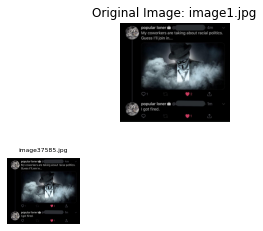

In [9]:
plot_duplicates(image_dir='/Users/Sid/Documents/FestoProject/MemeProject/Images',
                duplicate_map=duplicates,
                filename='image1.jpg')

So it looks like our CNN worked, now we'll export our duplicates dictionary as a link table in csv format so that we can plug it into our modified PageRank algorithm.

In [13]:
cleanDict=duplicates.copy()
for key in duplicates:
    if len(duplicates[key])>0:
        for k in duplicates[key]:
            try:
                if cleanDict[key] is not None:
                    cleanDict.pop(k,None)
            except:
                i=1
print(len(cleanDict))
print(len(duplicates))

23800
27778


In [12]:
with open('memeProject.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for key in cleanDict:
        if len(cleanDict[key])>0:
            for k in cleanDict[key]:
                kk=k.replace('.jpg', '')
                kk=kk.replace('image', '')
                kkk=key.replace('.jpg', '')
                kkk=kkk.replace('image', '')
                try:
                    output1=cleanerMemes[cleanerMemes.index==int(kk)]["Subreddit"].values[0]
                    output2=cleanerMemes[cleanerMemes.index==int(kkk)]["Subreddit"].values[0]
                    spamwriter.writerow([output1, output2])
                except:
                    print(kk)

In [75]:
maxD=0
outKey=0
for key in cleanDict:
    if len(cleanDict[key])>0:
        if len(cleanDict[key])>maxD:
            maxD=len(cleanDict[key])
            print(key)
            outKey=key
print(maxD)
print(outKey)       

image10055.jpg
image1011.jpg
image10281.jpg
image10737.jpg
282
image10737.jpg


In [61]:
print(len(duplicates["image10737.jpg"]))

282


In [ ]:
for key in sorted(cleanDict, key=lambda k: len(cleanDict[k]), reverse=True):
    print(key)

In [ ]:
cleanDict.pop("image10737.jpg",None)

In [42]:
res=list(sorted(duplicates, key=lambda k: len(duplicates[k]), reverse=True))

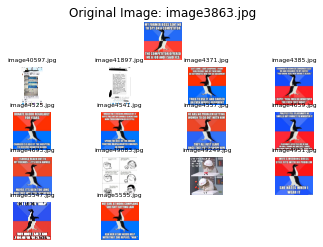

In [81]:
plot_duplicates(image_dir='/Users/Sid/Documents/FestoProject/MemeProject/Images',
                duplicate_map=duplicates,
                filename="image3863.jpg")

So first we removed duplicate entries of reduced meme template formats to a single entry containing all of the matched memes like shown in the image above.  We can see that there is some slight mismatch but for the most part the memes above are all the same format.  We then sorted them based on the number of duplicates in each format.  

# Weighted page rank

So now that we've effectively extended our data so now we have clusterings of each of the parameters of the original data set we will use our csv generated above and plug that into our modified page rank algorithm below.

In [2]:
dfMemes = pd.read_csv("Database.csv", encoding='UTF-8',skip_blank_lines=False)

subredditIndices = {}
index = 0
for subreddit in dfMemes["Subreddit"].unique():
    subredditIndices[subreddit] = index
    subredditIndices[index] = subreddit
    index += 1

In [3]:
dfLinks = pd.read_csv('memeProject.csv', header=None, encoding='utf8')
dfLinks.columns = ['i','j']

adjacencyList = [[] for n in range(index)]

for _, row in dfLinks.iterrows():
    subredditI = row["i"]
    subredditJ = row['j']
    i = subredditIndices[subredditI]
    j = subredditIndices[subredditJ]
    
    #links are bidirectional 
    #multiple links in memeProject.csv are added multiple times so they are counted later
    adjacencyList[j].append(i)
    adjacencyList[i].append(j)

In [4]:
from matplotlib.pyplot import figure

pd.set_option('display.max_rows', 500)

def stochasticMatrix(adjacency_list):
    n = len(adjacency_list)
    matrix = np.zeros((n, n))
    for col, line in enumerate(adjacency_list):
        if len(line) > 0:
              #page has existing links
            for index in line:
                
                matrix[index][col] += 1/(len(line)) #add a portion of the final weight
        else:
            #page not found
            for index in range(n):
                matrix[index][col] = 1/n
    return matrix

#transitionMatrix = (1-beta)/n * m + beta*stochasitcMatrix
def transitionMatrix(stochastic_matrix):
    n = len(stochastic_matrix)
    beta = 0.85 #teleportation factor
    m = np.ones((n, n)) #matrix of 1's
    part1 = np.multiply(((1-beta)/n), m)
    part2 = np.multiply(beta, stochastic_matrix)
    transition_matrix = np.add(part1, part2)
    return transition_matrix

def pageRank(transition_matrix):
    n = len(transition_matrix)
    err = 0.0005 
    v1 = np.ones(n)
    v1 = np.multiply((1/n), v1)
    v2 = np.matmul(transition_matrix, v1)
    
    while not within_err(v1, v2, err): 
        #ensures differences between v1 and v2 is under the err bound
        v1 = v2
        v2 = np.matmul(transition_matrix, v1)
    return (v2.tolist())

def within_err(v1, v2, err):
    diff_vector = np.subtract(v2, v1)
    for diff in diff_vector:
        if abs(diff) > err:
            return False
    return True


m = stochasticMatrix(adjacencyList)


t = transitionMatrix(m)


p = pageRank(t)


N = 10
#Return index values(company ids) for the 10 highest page ranks
topSubredditID = sorted(range(len(p)), key = lambda sub: p[sub])[-N:]

topSubreddits = [subredditIndices[subredditID] for subredditID in topSubredditID]





In [5]:
print(topSubreddits)

['gymmemes', 'badmemes', 'bee_irl', 'me_irl', 'christianmemes', 'kenm', 'bonehurtingjuice', 'adviceanimals', '2meirl4meirl', 'blackpeopletwitter']


So now we have our top ten memeist subreddits.  A quick visit to any of these subreddits will confirm that they have an abundance of memes (perhaps to no ones surprise).  One interesting thing however is that these subreddits are not necessarily the most popular based on traditional metrics such as number of users or upvotes.  That being said it is well known that these statistics (users and upvotes) can be easily gamed on any social network, so this suggests that our algorithm worked for more organically ranking subreddits.

In [40]:
edgeWeights=defaultdict(int)
for edge in adjacencyList[subredditIndices[topSubreddits[0]]]:
    if subredditIndices[edge] in topSubreddits:
        edgeWeights[subredditIndices[edge]]+=1
        
print(edgeWeights)

defaultdict(<class 'int'>, {'badmemes': 25, 'bee_irl': 4, '2meirl4meirl': 12, 'blackpeopletwitter': 7, 'bonehurtingjuice': 33, 'christianmemes': 27, 'gymmemes': 82, 'me_irl': 7, 'adviceanimals': 1})


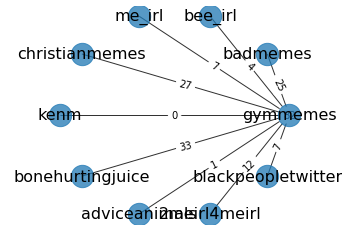

In [56]:
G=nx.Graph()
nodes=topSubreddits
G.add_nodes_from(nodes)
for reddit in topSubreddits:
    G.add_edge(topSubreddits[0],reddit,weight=edgeWeights[reddit])
    
pos = nx.kamada_kawai_layout(G) #algorithm that tries to "cluster" node plot locations
labels=dict(zip(topSubreddits,topSubreddits))
nx.draw_networkx_nodes(G, pos, cmap='Pastel1', node_size=500, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.8); #draw edges
nx.draw_networkx_labels(G, pos, labels, font_size=16); #label vertices by index/number
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.margins(x=0.23)
plt.axis("off");
    

In [11]:
subredditIndices[3]

'adviceanimals'

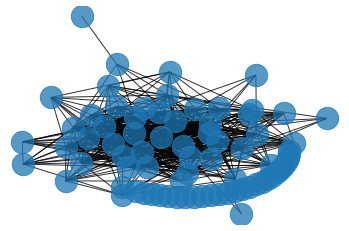

In [39]:
edges=defaultdict(lambda: defaultdict(int))
for _, row in dfLinks.iterrows():
    edges[subredditIndices[row["i"]]][subredditIndices[row["j"]]]+=1
edgeList=[]
for x in edges:
    for y in edges[x]:
        edgeList.append([x,y])
    
G=nx.Graph()
nodes=[i for i in range(76)]
G.add_nodes_from(nodes)
for i in range(len(edgeList)):
    G.add_edge(edgeList[i][0],edgeList[i][1])
    
pos = nx.kamada_kawai_layout(G) #algorithm that tries to "cluster" node plot locations
labels=dict(zip(range(76),range(76))); #label 0-20
nx.draw_networkx_nodes(G, pos, cmap='Pastel1', node_size=500, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.8); #draw edges
#nx.draw_networkx_labels(G, pos, labels, font_size=16); #label vertices by index/number
plt.axis("off");

In [35]:
edges=defaultdict(lambda: defaultdict(int))
for _, row in dfLinks.iterrows():
    edges[subredditIndices[row["i"]]][subredditIndices[row["j"]]]+=1
edgeList=[]
for x in edges:
    for y in edges[x]:
        edgeList.append([x,y])
print(edgeList)

[[23, 1], [23, 7], [23, 8], [23, 9], [23, 2], [23, 14], [23, 15], [23, 16], [23, 19], [23, 20], [23, 21], [23, 22], [23, 23], [23, 3], [23, 25], [23, 45], [23, 47], [12, 6], [12, 8], [12, 9], [12, 2], [12, 12], [12, 14], [12, 15], [12, 30], [12, 45], [36, 6], [36, 8], [36, 9], [36, 12], [36, 2], [36, 15], [36, 19], [36, 20], [36, 1], [36, 3], [36, 27], [36, 28], [36, 29], [36, 30], [36, 33], [36, 34], [36, 35], [36, 36], [36, 37], [36, 38], [36, 39], [36, 46], [36, 47], [47, 6], [47, 7], [47, 8], [47, 1], [47, 9], [47, 10], [47, 2], [47, 12], [47, 14], [47, 15], [47, 16], [47, 19], [47, 20], [47, 21], [47, 22], [47, 23], [47, 26], [47, 3], [47, 29], [47, 30], [47, 33], [47, 34], [47, 35], [47, 36], [47, 37], [47, 38], [47, 41], [47, 42], [47, 4], [47, 44], [47, 45], [47, 46], [47, 47], [50, 6], [50, 7], [50, 8], [50, 9], [50, 12], [50, 14], [50, 2], [50, 15], [50, 19], [50, 22], [50, 23], [50, 30], [50, 33], [50, 34], [50, 35], [50, 36], [50, 38], [50, 40], [50, 42], [50, 44], [50, 46]